In [1]:
import scvi
import torch
import anndata
import umap
import joblib
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scarches as sca

/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
 captum (see https://github.com/pytorch/captum).


In [3]:
EMTABfemale = sc.read("/home/zhoujian/human/data/E-MTAB-10551/E-MTAB-10551-female.h5ad")
EMTABmale = sc.read("/home/zhoujian/human/data/E-MTAB-10551/E-MTAB-10551-male.h5ad")
GSE124263 = sc.read("/home/zhoujian/human/data/GSE24263/GSE143381_adult_combined.h5ad")
GSE86146 = sc.read("/home/zhoujian/human/data/GSE86146/GSE86146.h5ad")
GSE143381 = sc.read("/home/zhoujian/human/data/GSE143381/GSE143381.h5ad")
HRA000344 = sc.read("/home/zhoujian/human/data/HRA000344/HRA000344.h5ad")
GSE120508 = sc.read("/home/zhoujian/human/data/GSE120508/GSE120508.h5ad")

In [75]:
adata = sc.concat(
    [EMTABmale, GSE120508, GSE86146, GSE143381, HRA000344,EMTABfemale],
    join="inner",
    index_unique=None,
    merge="unique"
)

In [76]:
adata.layers["counts"] = adata.X.copy()
adata.raw = adata.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 24291 × 20717
    obs: 'Stage', 'Gender', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell type', 'sample', 'batch'
    var: 'mt'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [78]:
hvgs = []
for sex in ['male', 'female']:
    idx = adata.obs['Gender'].str.lower().eq(sex)
    ad = adata[idx].copy()
    sc.pp.highly_variable_genes(
        ad,
        flavor='cell_ranger',     # 稳定，期望原始计数
        n_top_genes=2000,
        batch_key='batch',     # 若没有 sample 列就去掉这一行
        layer="counts",
        subset=False,           # 只标记，不裁剪；方便之后取并集
    )
    hvgs.append(pd.Index(ad.var_names[ad.var['highly_variable']]))

# 2) 取并集并标回原对象
hvg_union = hvgs[0].union(hvgs[1])
adata.var['highly_variable'] = adata.var_names.isin(hvg_union)
print(f"HVG 并集基因数：{adata.var['highly_variable'].sum()}")

# （可选）3) 只保留这些 HVGs，便于 scvi 更快
adata_hvg = adata[:, adata.var['highly_variable']].copy()
print("子集后形状：", adata_hvg.shape)

HVG 并集基因数：3069
子集后形状： (24291, 3069)


In [80]:
adata = adata[:, adata.var['highly_variable']].copy()
adata.uns['log1p']["base"] = None
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key="batch",
)


In [81]:
vae = scvi.model.SCVI(adata, n_layers=2, gene_likelihood='nb')
vae.train(max_epochs=400, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 254/400:  64%|██████▎   | 254/400 [06:50<03:56,  1.62s/it, v_num=1, train_loss_step=1.51e+3, train_loss_epoch=1.43e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1471.552. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

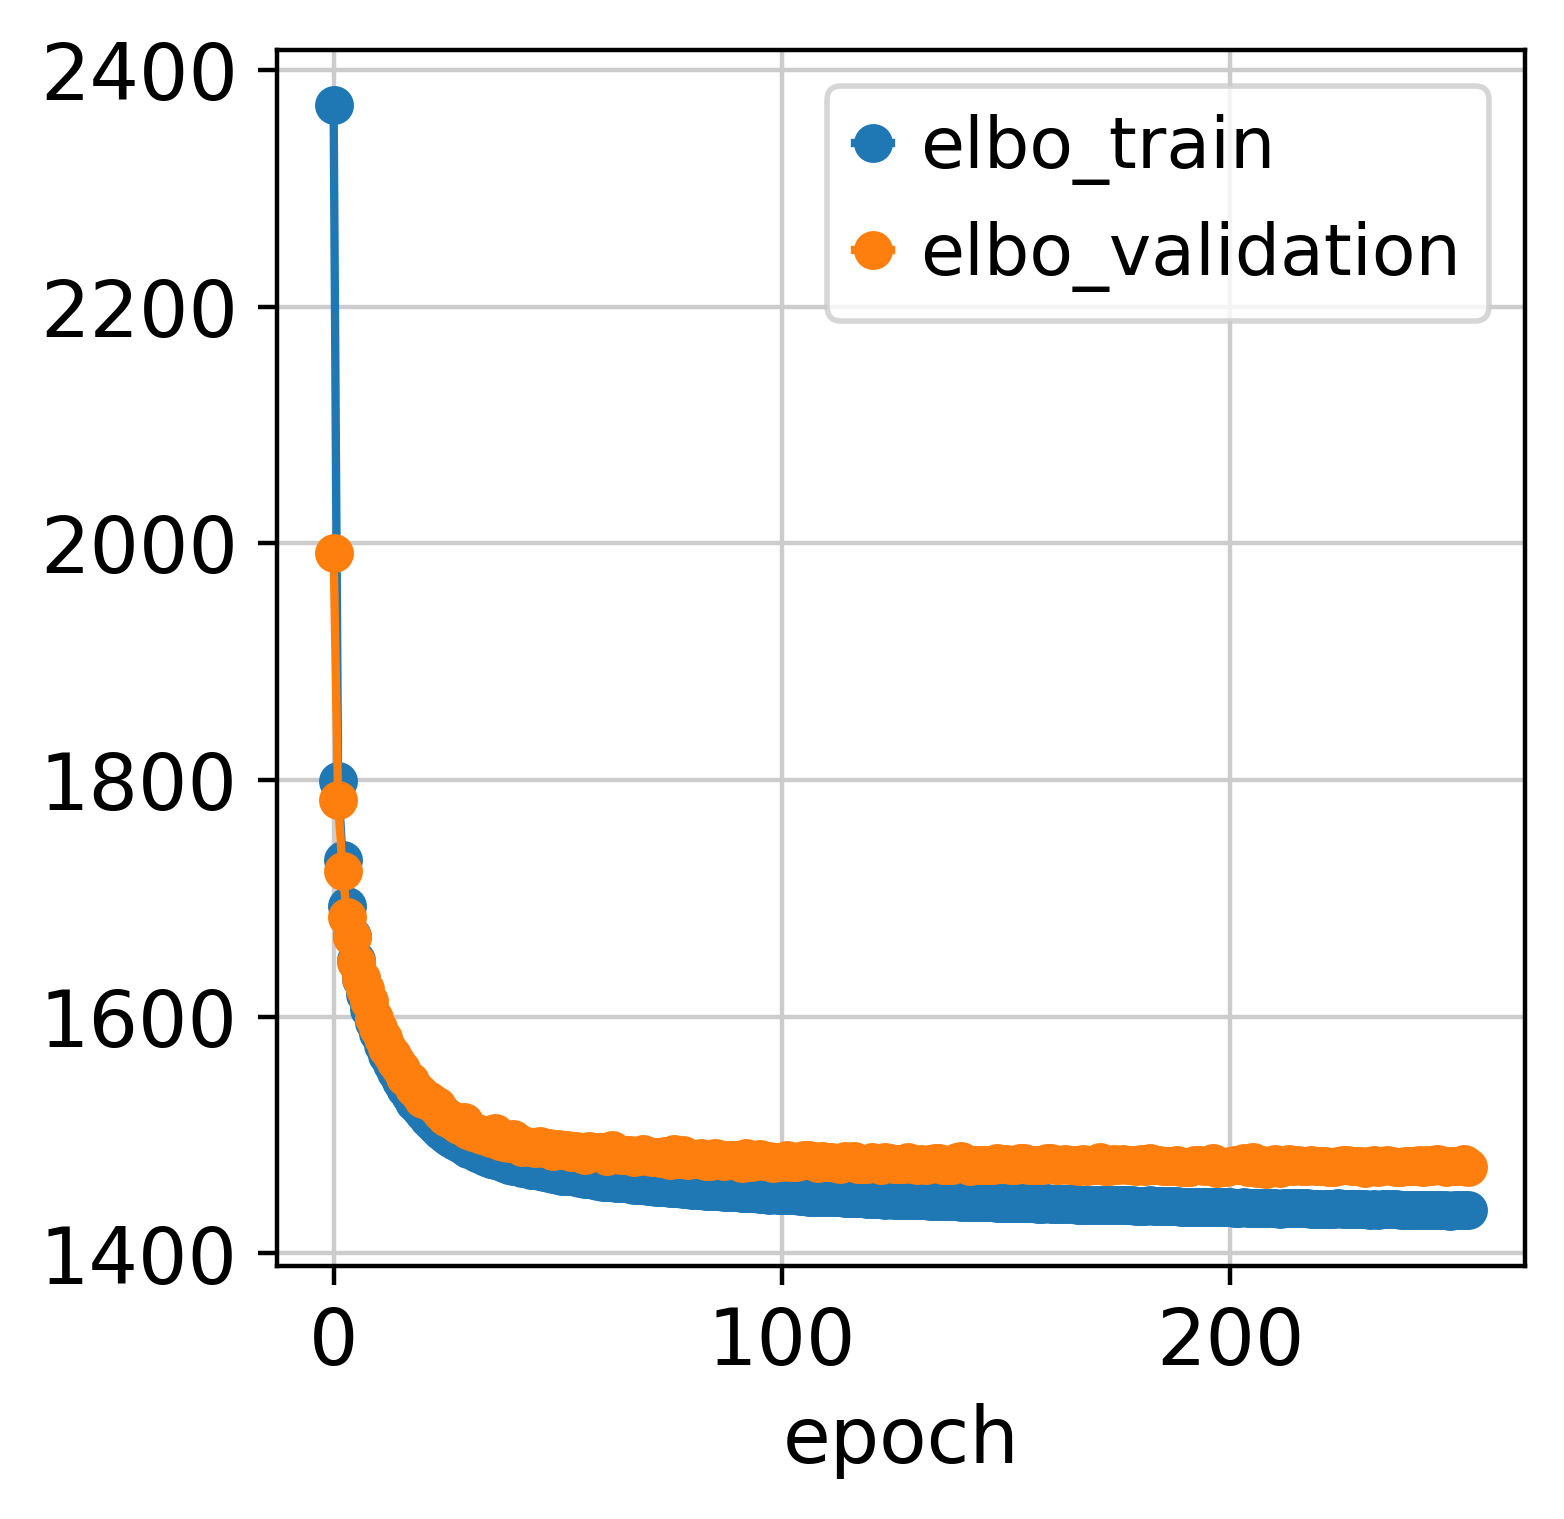

In [82]:
pd.concat([vae.history['elbo_train'], vae.history['elbo_validation']], axis=1).plot.line(marker='o')

In [202]:
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata=adata, labels_key="cell type", unlabeled_category="Unknown")
lvae.train(max_epochs=20, n_samples_per_label=15)
# lvae2 = scvi.model.SCANVI.from_scvi_model(vae, adata=adata, labels_key="cell type2", unlabeled_category="Unknown")
# lvae2.train(max_epochs=20, n_samples_per_label=15)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|██████████| 20/20 [01:06<00:00,  3.20s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.43e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:06<00:00,  3.34s/it, v_num=1, train_loss_step=1.53e+3, train_loss_epoch=1.43e+3]


In [ ]:
ref_z = lvae.get_latent_representation()
umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.3,
    metric="euclidean",      # 与 Scanpy 默认为同一设置
    random_state=0
)
adata.obsm["X_umap"] = umap_model.fit_transform(ref_z)

In [348]:
joblib.dump(umap_model, "model/umap_scANVI_model.joblib")
lvae.save("model/cell_type_scanvi_model", overwrite=True)
vae.save("model/cell_type_scvi_model", overwrite=True)
adata.write_h5ad("re/adata_processed.h5ad") 

['model2/umap_scANVI_model.joblib']

In [250]:
lvae2.adata.obs['predictions'] = lvae2.predict()
lvae2.adata.obs['entropy'] = 1 - lvae2.predict(soft=True).max(axis=1)
mtx_oder = lvae2.adata.obs['cell type2'].cat.categories.tolist()
mtx = sc.metrics.confusion_matrix("cell type2", "predictions", lvae2.adata.obs).loc[mtx_oder, mtx_oder]
entropy = lvae2.adata.obs.groupby(['predictions']).mean(numeric_only=True)['entropy'][mtx_oder]

In [252]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
accuracy = accuracy_score(lvae2.adata.obs['cell type2'].values, lvae2.adata.obs.predictions.values)
balanced_acc = balanced_accuracy_score(lvae2.adata.obs['cell type2'].values, lvae2.adata.obs.predictions.values)
f1_micro = f1_score(lvae2.adata.obs['cell type2'].values, lvae2.adata.obs.predictions.values, average="micro")
f1_macro = f1_score(lvae2.adata.obs['cell type2'].values, lvae2.adata.obs.predictions.values, average="macro")

# 拼接结果字符串
metrics_str = (
    f'Accuracy score: {accuracy}\n'
    f'Balanced accuracy: {balanced_acc}\n'
    f'F1 (micro): {f1_micro}\n'
    f'F1 (macro): {f1_macro}'
)

# 打印指标
print(metrics_str)

Accuracy score: 0.7662920423202009
Balanced accuracy: 0.8906015921230446
F1 (micro): 0.7662920423202009
F1 (macro): 0.6964470356817751


/tmp/ipykernel_494060/3009194284.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


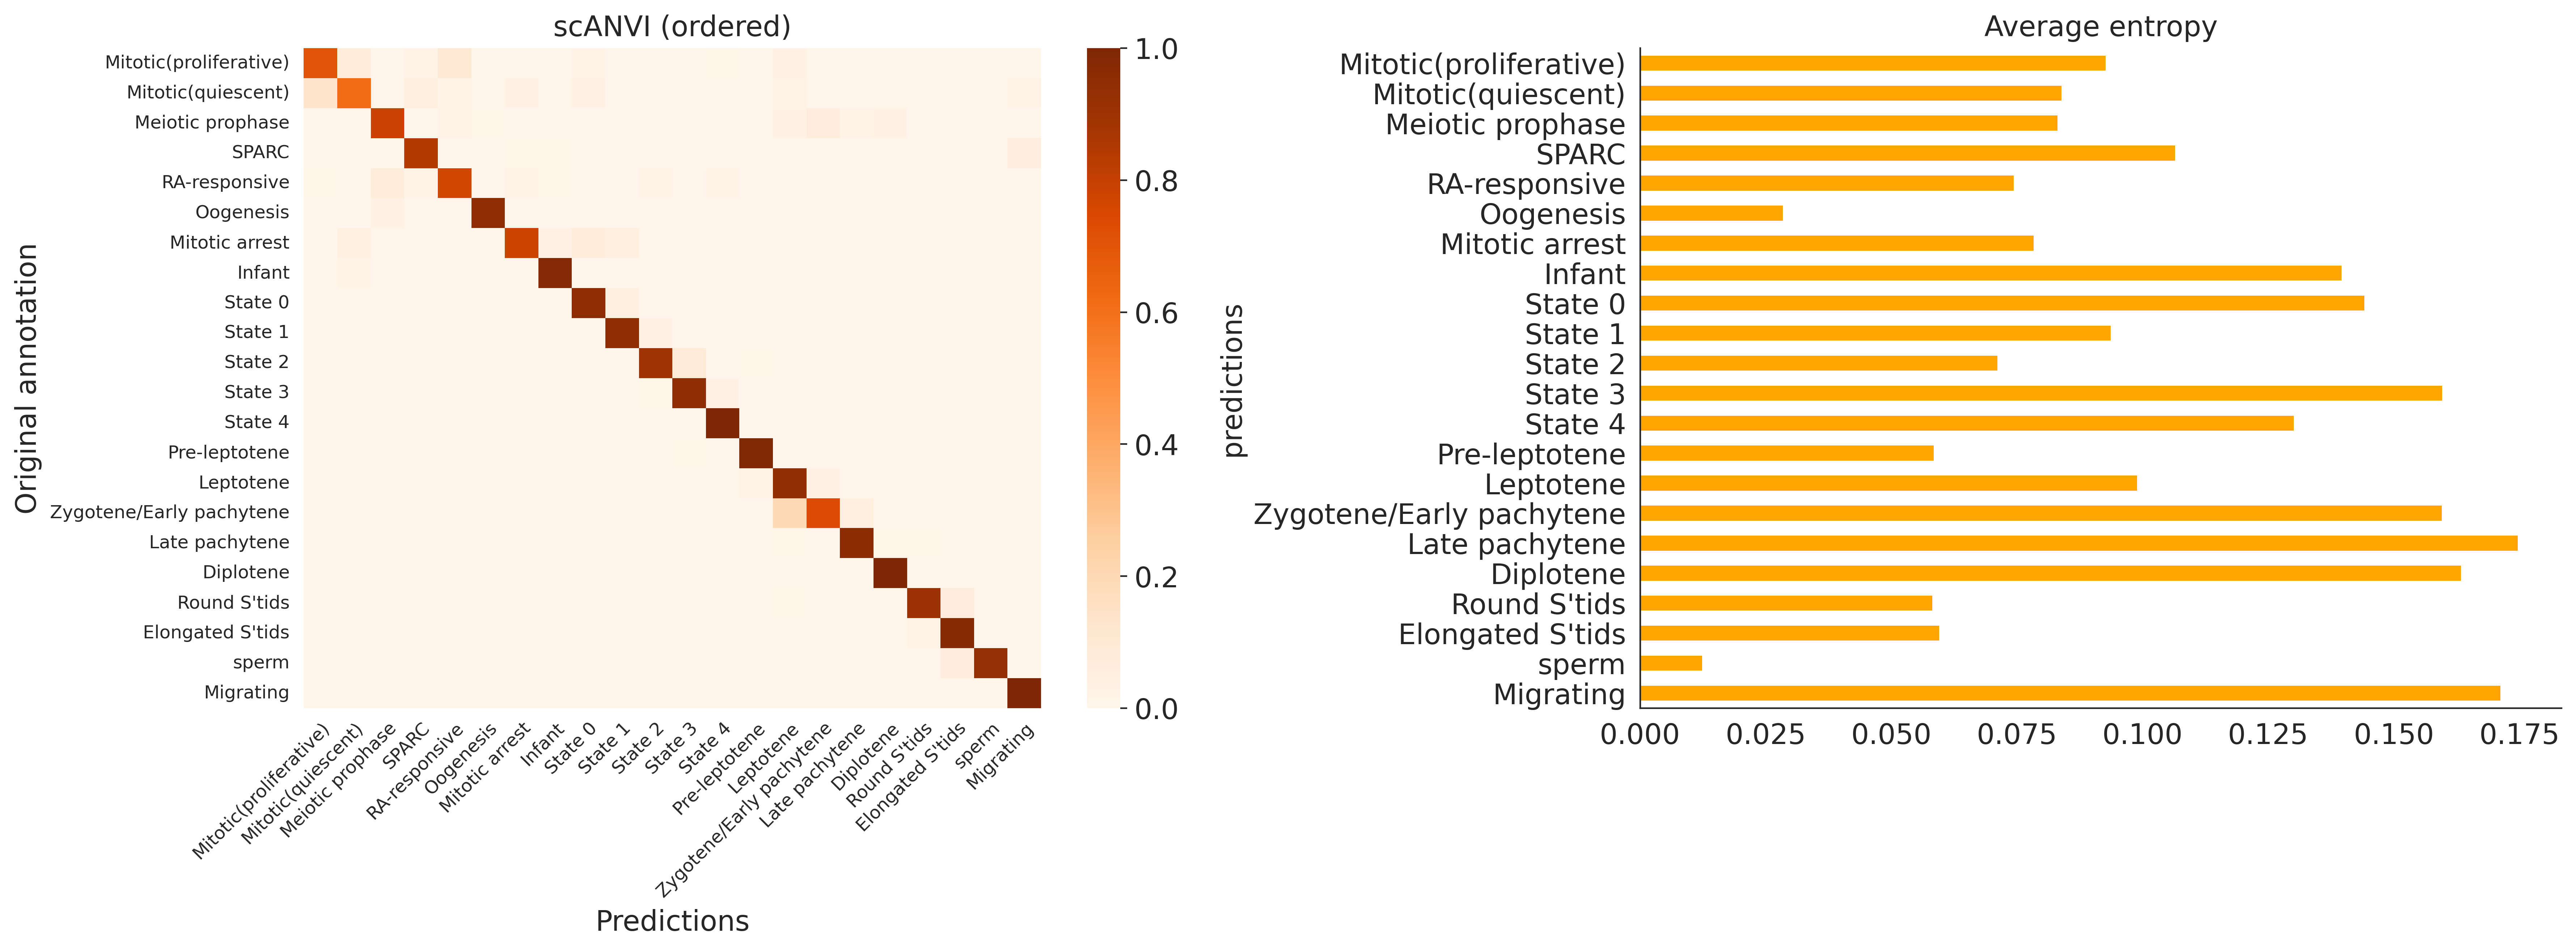

In [254]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

# === 1) 定义发育顺序（按你的项目改即可）===
dev_order = ["Mitotic(proliferative)","Mitotic(quiescent)","Meiotic prophase","SPARC","RA-responsive","Oogenesis","Mitotic arrest","SSCs",
             "Differentiating S'gonia","Infant","State 0","State 1","State 2","State 3","State 4","Pre-leptotene","Leptotene","Zygotene/Early pachytene","Late pachytene","Diplotene",
             "Early primary S'cytes","Late primary S'cytes","Round S'tids","Elongated S'tids","sperm"]

# 只保留实际存在的类别；其余（若有）排到最后
idx_order = [x for x in dev_order if x in mtx.index]   + [x for x in mtx.index   if x not in dev_order]
col_order = [x for x in dev_order if x in mtx.columns] + [x for x in mtx.columns if x not in dev_order]

mtx_ord = mtx.reindex(index=idx_order, columns=col_order)

# 条形图（假设 entropy 的 index 与“预测类别”一致；若与行对应就用 idx_order）
ent_order = [x for x in col_order if x in entropy.index] + [x for x in entropy.index if x not in col_order]
ent_ord   = entropy.reindex(ent_order)

# === 2) 作图（去格线、右图同序）===
sns.set_style("white")

fig, ax = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'wspace': 0.45})

# 左：热图（按发育顺序）
hm = sns.heatmap(
    mtx_ord, cmap='Oranges', vmin=0, vmax=1,
    linewidths=0, linecolor='none',
    cbar=True, ax=ax[0], square=False  # square=False 更不拥挤
)
hm.set(xlabel='Predictions', ylabel='Original annotation', title='scANVI (ordered)')
for s in ax[0].spines.values(): s.set_visible(False)
# X 轴刻度：旋转 + 字号 + 间距
ax[0].tick_params(axis='x', labelrotation=45, labelsize=9, pad=2)

# 设置水平对齐到右侧（避免换行遮挡），并固定旋转模式
plt.setp(ax[0].get_xticklabels(), ha='right', rotation_mode='anchor')

# Y 轴刻度：不旋转，字号略小
ax[0].tick_params(axis='y', labelrotation=0, labelsize=9)

# 右：条形图（按同一顺序）
ent_ord.plot.barh(ax=ax[1], title='Average entropy',
                  color='Orange', edgecolor='none')
ax[1].invert_yaxis()        # 与左图自上而下方向一致
ax[1].grid(False)
sns.despine(ax=ax[1])

fig.tight_layout()
fig.savefig("fig/scANVI_cell_type2_results_ordered.svg", bbox_inches='tight')
fig.savefig("fig/scANVI_cell_type2_results_ordered.pdf", bbox_inches='tight')
plt.show()

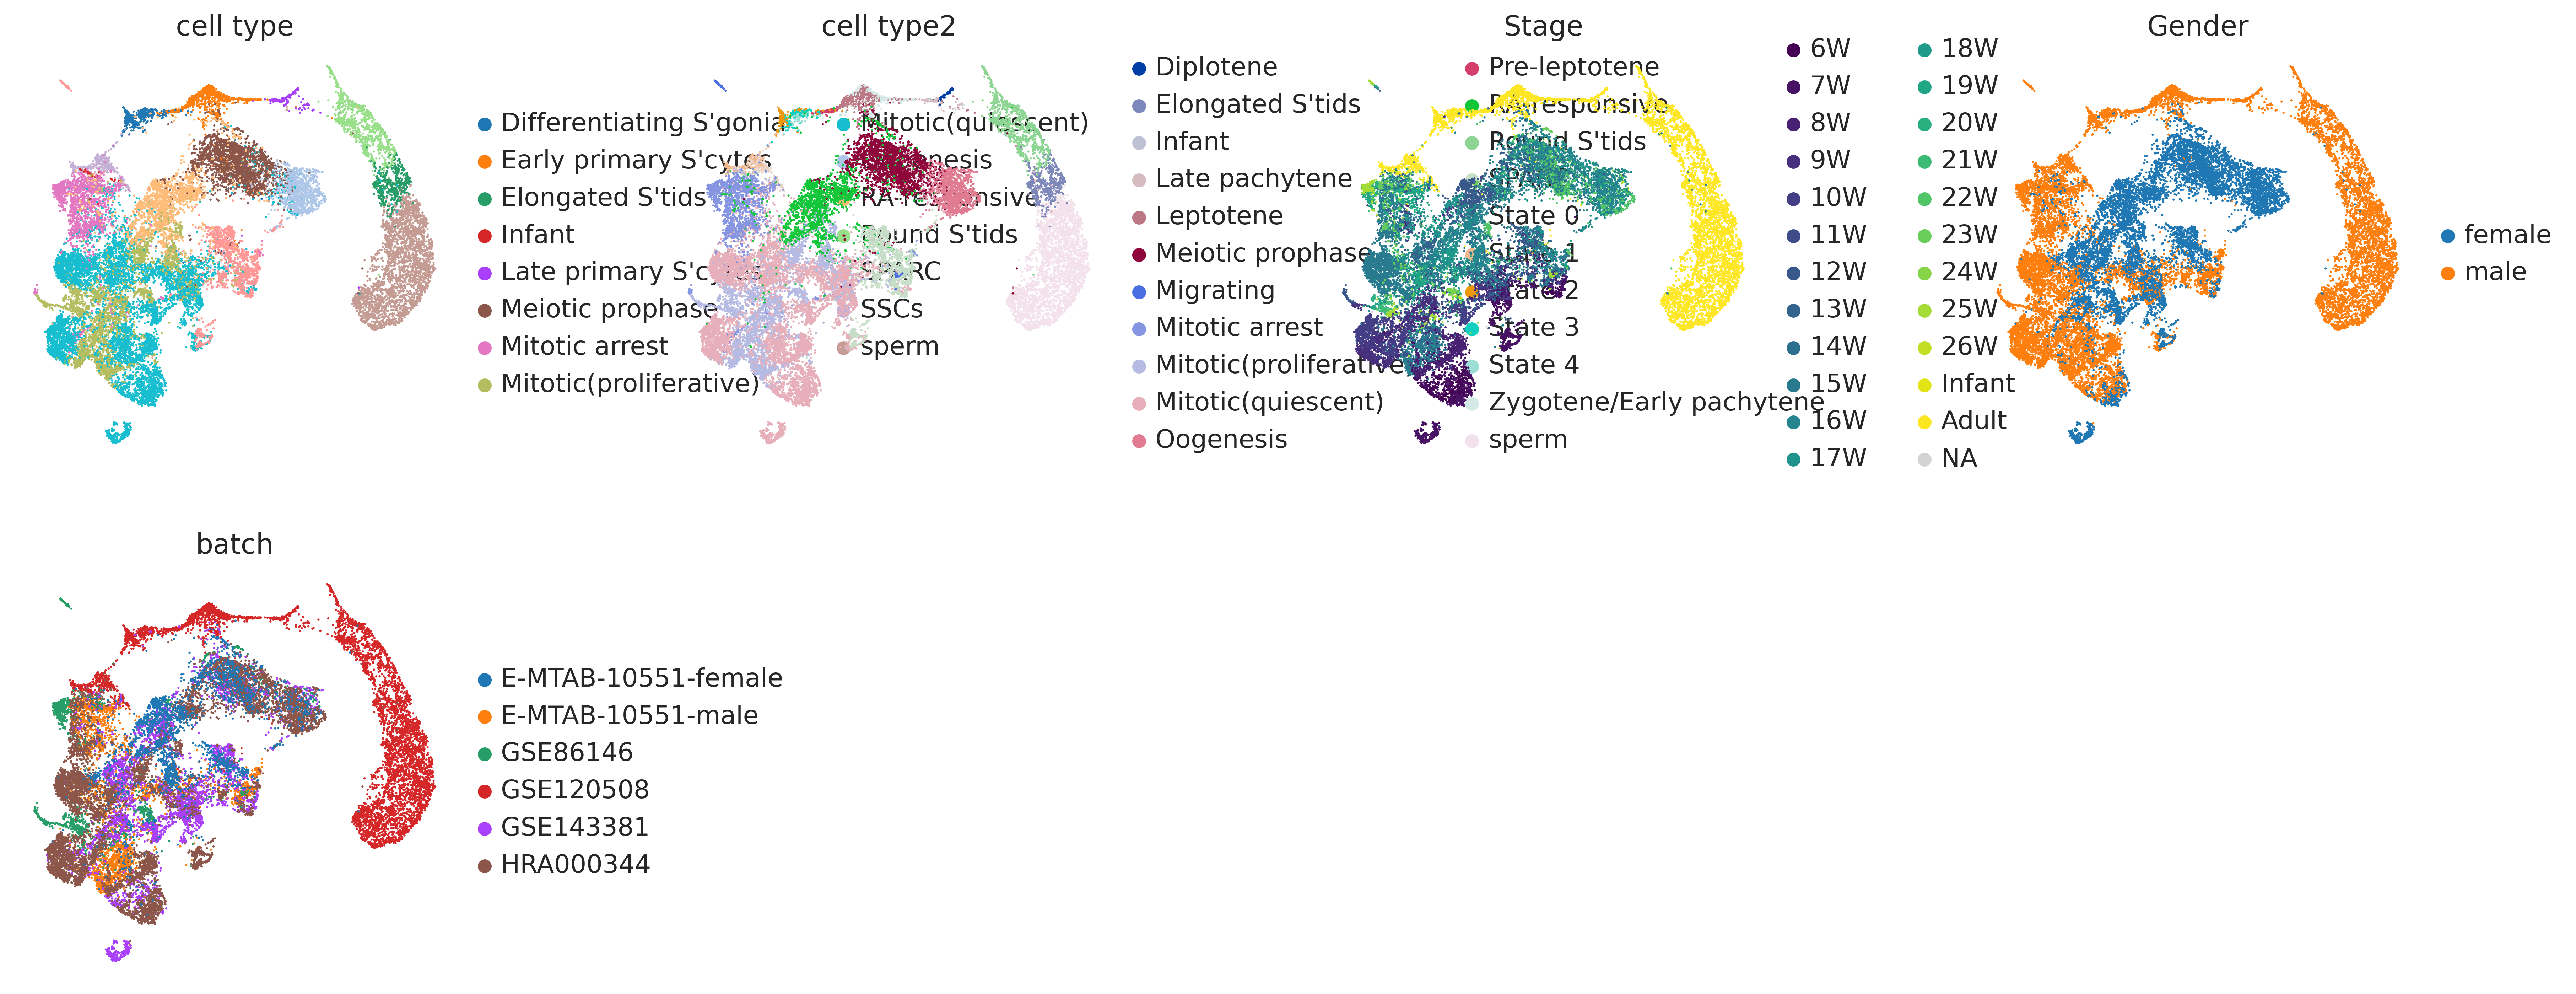

In [275]:
sc.pl.embedding(
    adata, 
    basis="umap", 
    color=["cell type", "cell type2", "Stage", "Gender", "batch"], 
    legend_loc="right margin", 
    na_color="lightgray",
    wspace=0.35, 
    frameon=False,
    color_map='viridis'  # 或选择其他调色板
)

In [321]:
from harmony import harmonize
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
adata.obsm["Harmony_scVI"] = harmonize(adata.obsm["X_scVI"], adata.obs, batch_key="batch")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [322]:
from harmony import harmonize

adata.obsm["Harmony_PCA"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
Reach convergence after 10 iteration(s).


In [324]:
bm2 = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell type",
    embedding_obsm_keys=['X_scVI', 'X_pca', 'X_scANVI', 'Harmony_PCA', 'Harmony_scVI'],
    n_jobs=-1,
)
bm2.benchmark()

/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:439: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]WARNING:jax._src.xla_bridge:An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  60%|██████    | 6/10 [00:15<00:08,  2.04s/it, Batch correction: kbet_per_label]

INFO     15 clusters consist of a single batch or are too small. Skip.                                             


/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

Metrics:  70%|███████   | 7/10 [00:15<00:04,  1.51s/it, Batch correction: graph_connectivity]/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  20%|██        | 1/5 [00:16<01:05, 16.48s/it]atch correction: pcr_comparison]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:49<00:19,  4.88s/it, Batch correction: kbet_per_label]

INFO     15 clusters consist of a single batch or are too small. Skip.                                             


/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

Metrics:  70%|███████   | 7/10 [00:49<00:10,  3.42s/it, Batch correction: graph_connectivity]/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  40%|████      | 2/5 [01:06<01:48, 36.13s/it]atch correction: pcr_comparison]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:07<00:03,  1.30it/s, Batch correction: kbet_per_label]

INFO     15 clusters consist of a single batch or are too small. Skip.                                             


/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

Metrics:  70%|███████   | 7/10 [00:07<00:01,  1.53it/s, Batch correction: graph_connectivity]/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  60%|██████    | 3/5 [01:14<00:46, 23.20s/it]atch correction: pcr_comparison]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:53<00:20,  5.05s/it, Batch correction: kbet_per_label]

INFO     15 clusters consist of a single batch or are too small. Skip.                                             


/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

Metrics:  70%|███████   | 7/10 [00:54<00:10,  3.53s/it, Batch correction: graph_connectivity]/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings:  80%|████████  | 4/5 [02:08<00:35, 35.52s/it]atch correction: pcr_comparison]
                                                                                         
Metrics:  60%|██████    | 6/10 [00:06<00:02,  1.46it/s, Batch correction: kbet_per_label]

INFO     15 clusters consist of a single batch or are too small. Skip.                                             


/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_kbet.py:212: RuntimeWarning: Mean of empty slice
  final_score = np.nanmean(kbet_scores["kBET"])

Metrics:  70%|███████   | 7/10 [00:06<00:01,  1.68it/s, Batch correction: graph_connectivity]/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scib_metrics/metrics/_graph_connectivity.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|██████████| 5/5 [02:15<00:00, 27.13s/it]atch correction: pcr_comparison]

                                                                                         

/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


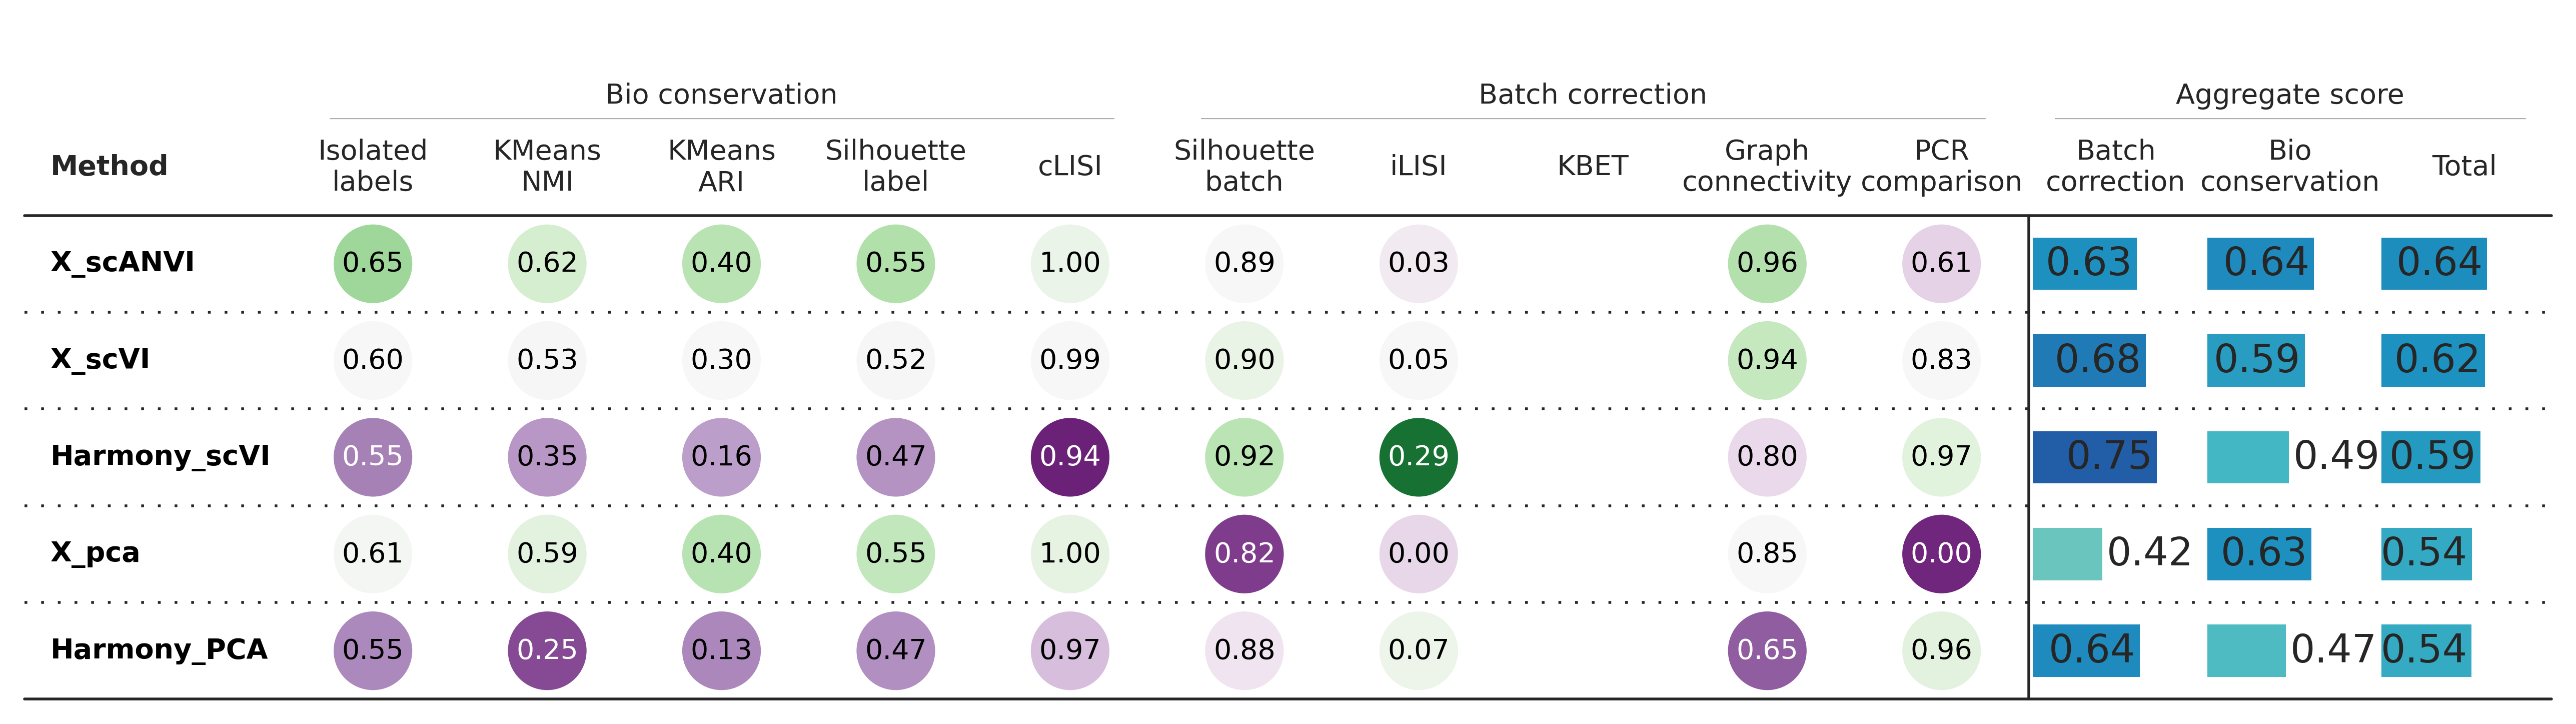

In [325]:
bm2.plot_results_table(min_max_scale=False)

In [326]:
from scanvi_explainer import SCANVIDeep, SCANVIBoostrapper
from scanvi_explainer.plots import feature_plot
import shap

In [327]:
bootstrapper = SCANVIBoostrapper(lvae, n_bootstraps=10)

In [328]:
shap_values = bootstrapper.run(train_size=0.8, batch_size=64)

  0%|          | 0/10 [00:00<?, ?it/s]/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scanvi_explainer/utils.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = adata.obs.groupby(groupby)

 10%|█         | 1/10 [01:56<17:30, 116.77s/it]/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scanvi_explainer/utils.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = adata.obs.groupby(groupby)

 20%|██        | 2/10 [04:32<18:37, 139.74s/it]/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scanvi_explainer/utils.py:82: FutureWarning: The default of observ

In [331]:
e = SCANVIDeep(lvae, train_size=0.8, batch_size=128)
e

/home/zhoujian/anaconda3/envs/scvi/lib/python3.11/site-packages/scanvi_explainer/utils.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = adata.obs.groupby(groupby)


SCANVIDeep with the following parameters:
train_size=0.8, test_size=0.2, batch_size=128, labels_key=cell type, layers_key=counts
training_on=cuda:0

In [333]:
shap_values_ = e.shap_values()

100%|██████████| 15/15 [07:04<00:00, 28.31s/it]


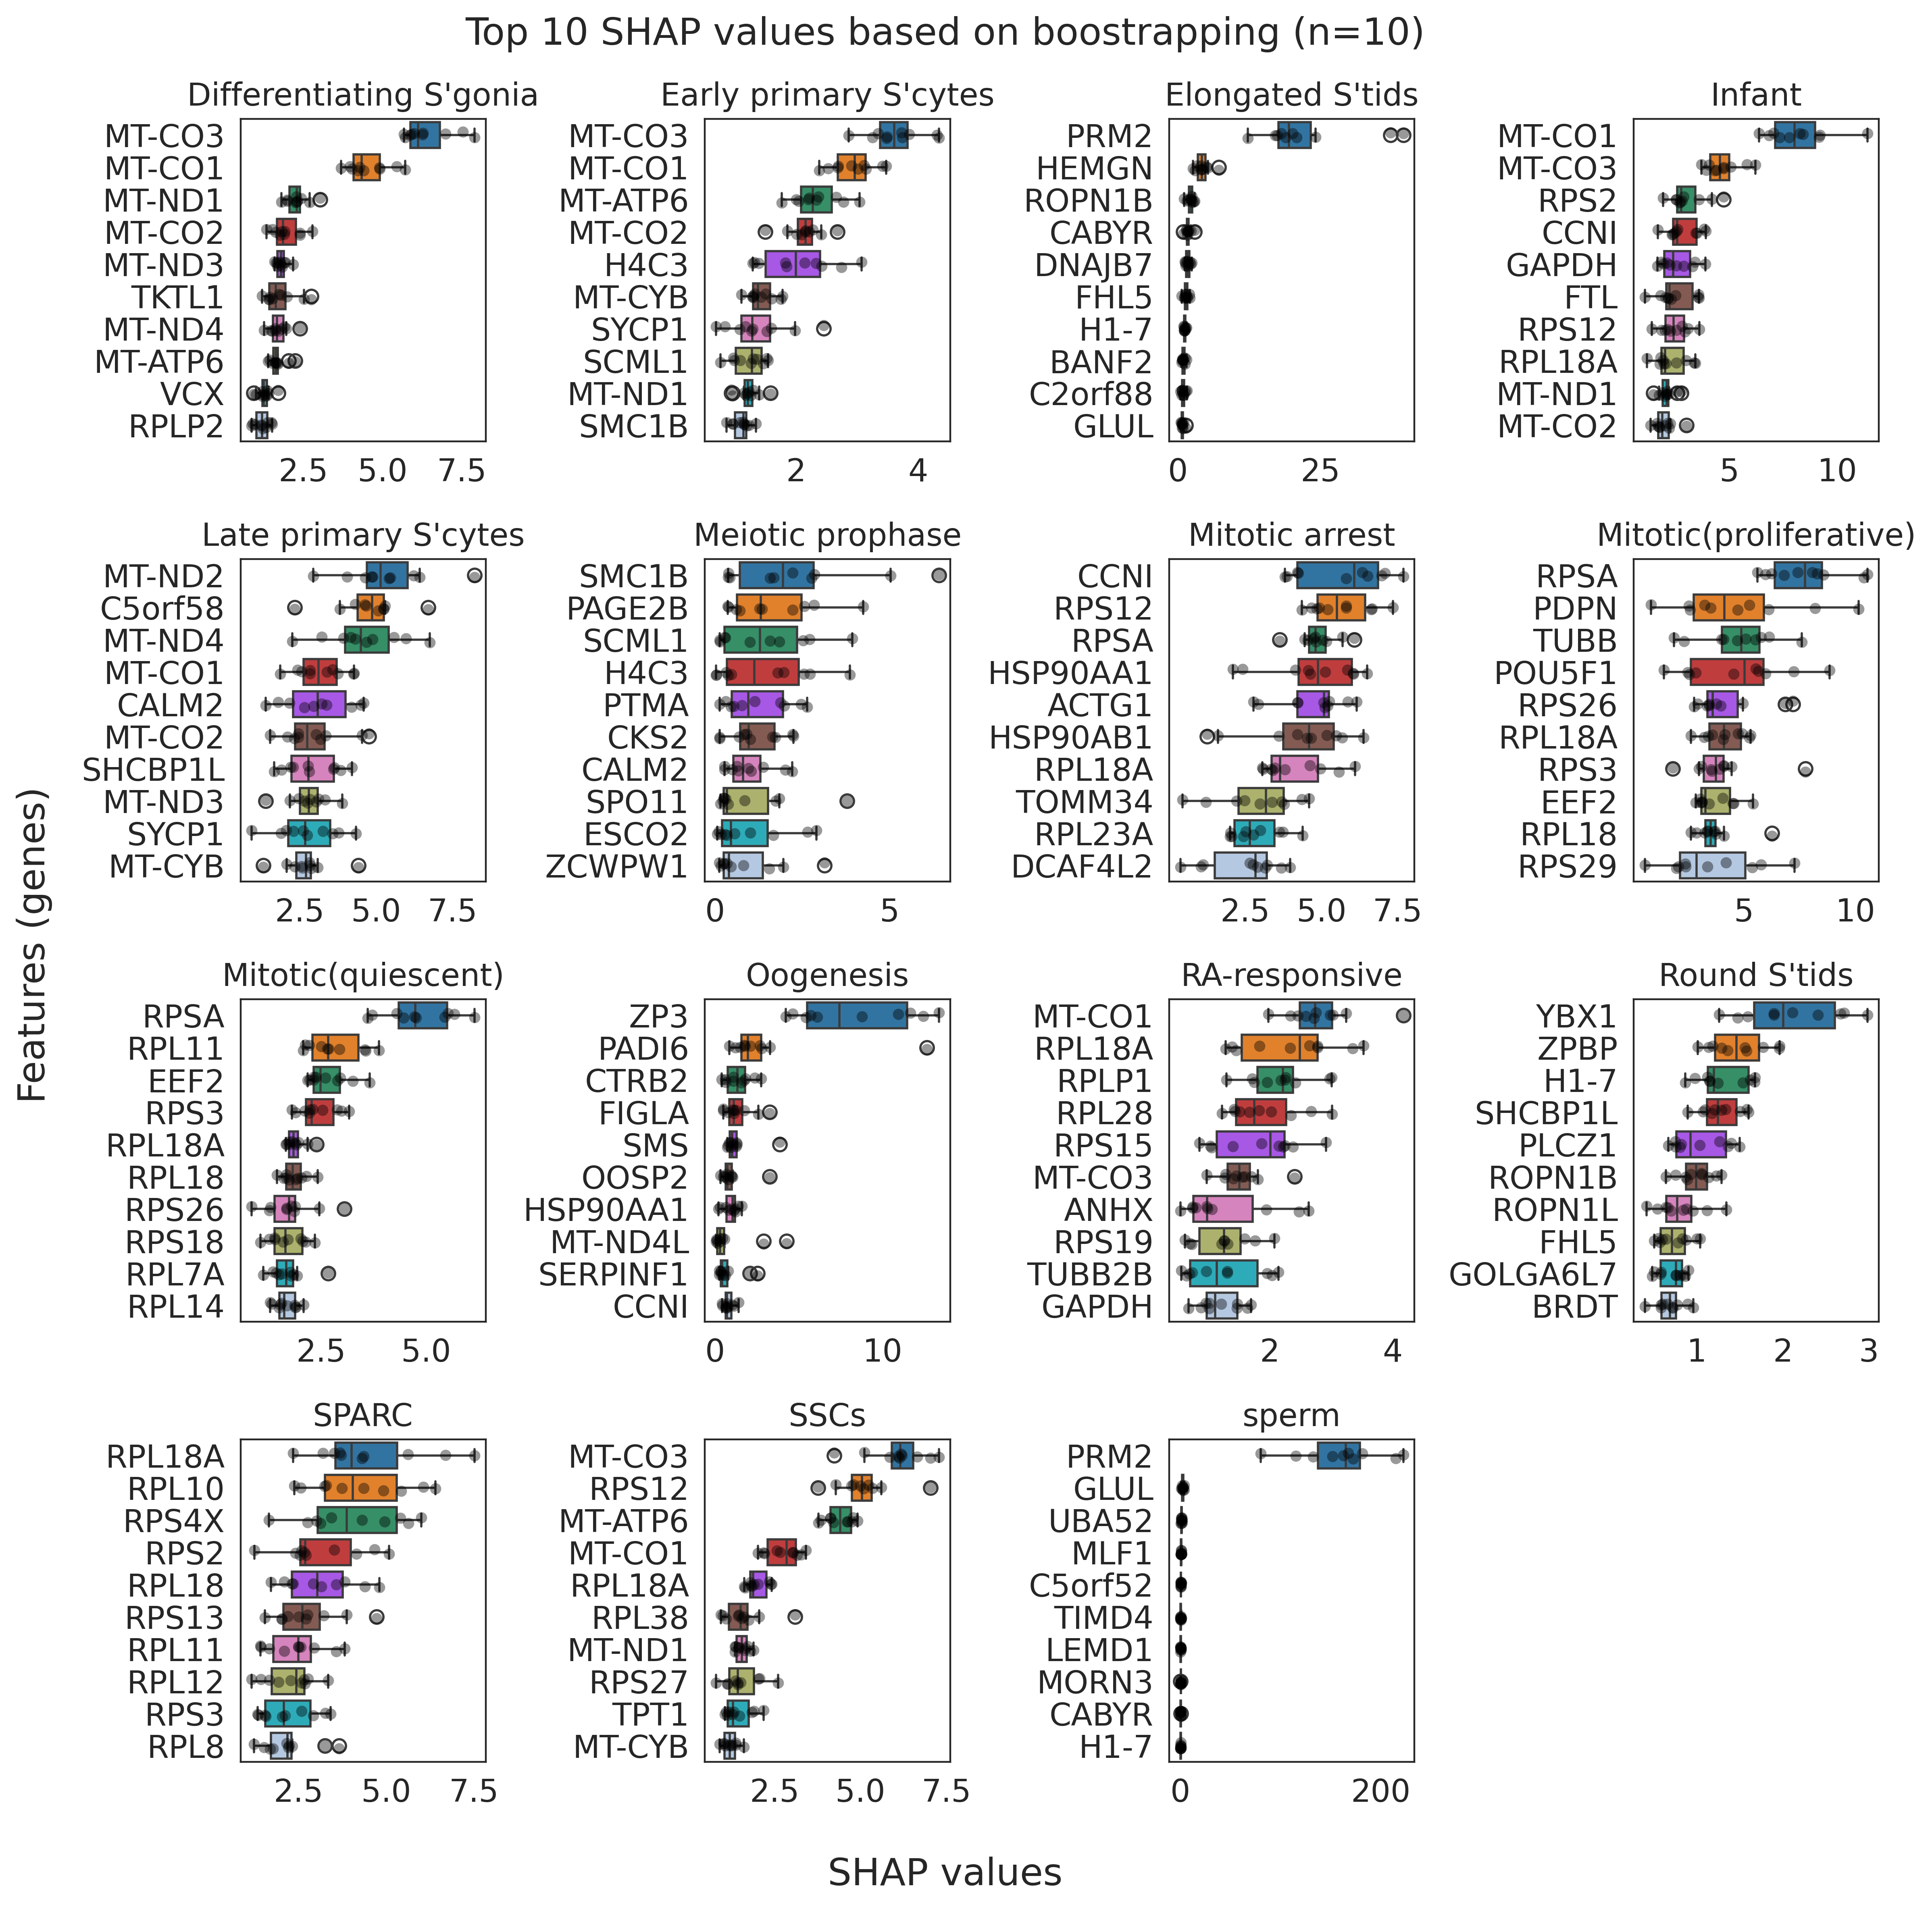

In [338]:
bootstrapper.feature_plot(shap_values, n_cols=4, figsize=(12, 12))
fig = plt.gcf()
# fig.set_size_inches(12, 30)
plt.savefig("fig2/bootstrap_feature_cell_type.svg", format="svg")